# Using SVM Seperating Plane Distance as a Feature

Support Vector Machines (SVM) are one of my favorite machine learning algorithms. I have decided to make a set of blog posts to explore tricks for dealing with SVMs. Usually SVMs are employed as black box binary classifiers. In this post we are going to explore using the underlying SVMs representation to generate features to use as input for further calculation (for example as an input to other classifiers).

<!-- TEASER_END -->


## What is a Support Vector Machine (SVM)?

Like many machine learning algorithms a support vector machine classifier may be viewed as a combination of some sort of non-linear feature transform followed by the application of a linear seperator. For example in the case of a neural network one may view all layers up to but excluding the output layer as a feature transform and the weights in the output layer as the coefficients of hyperplanes that seperate the target classes in the space of transformed features. 

In the case of neural networks the feature transform is learned from the data, can be carried out explicitly, and usually involves a dimensionality reduction. Support vector machines lie at the opposite end of this spectrum. For SVM's the feature transform is determined entirely a-priori instead of being learned, the feature transform is implicit and often infeasible to calculate explicitly, and most importantly the feature transform usually implies a drammatic <i> increase </i> in the number of features.

Support vector machines can get away with this explosion of feature dimensionality because they utilize something called the kernel trick. The kernel trick is to learn a representation for your decision function whose coefficients represent weights for training examples which correspond to a seperating hyperplane in your high dimensional feature space. 

https://en.wikipedia.org/wiki/Kernel_method

## Signed Orthogonal Distance as a Feature

To apply an SVM classifier to a given data point we first determine the signed orthogonal distance of that point to our learned class separating hyperplane. To do this we take a dot product in the implicit feature space between the normal vector of the separating hyper plane (the normal vector of a plane is the vector perpendicular to the plane) and the test point. If the plane is zero-centered this dot product is equal to the orthogonal distance to the hyper plane multiplied by +1 for points on the side that the normal points towards side and -1 for points on the other. If the plane does not go through zero then this dot product is this distance plus some constant bias.

Instead of simply taking the sign of this dot product as our classification it can often be helpful to treat the SVM as a feature extraction step and use the distance to the learned hyperplane as an additional feature which we can then apply other algorithms to. In particular we can pass this to simple probabilistic models such as GaussianNB to turn the results into a probability. This is especially useful when the metric we are trying to optimize (e.g. area under the ROC curve) differs from the hinge loss that is used to fit the SVM.   

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

%matplotlib inline

import sklearn
from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn.naive_bayes
import sklearn.ensemble

In [44]:
plt.rcParams.update(
    {
        "font.size":16,
        "image.cmap":"afmhot",
        "image.interpolation":"nearest",
        "figure.figsize":(12, 5),
    }
)

# Digits Example

We go to a hand written digits dataset as an easy example. We use the built in sklearn digits data instead of MNIST to keep the examples fast to run. This dataset turns out to be too small to really explore this technique but it is still an interesting example.


In [3]:
digits_ds = load_digits()

input_features = digits_ds["data"]
labels = digits_ds["target"]

In [4]:
n_train = 1000

train = input_features[:n_train]
train_labels = labels[:n_train]

test = input_features[n_train:]
test_labels = labels[n_train:]

We begin with the LinearSVC classifier. The LinearSVC classifier just finds a maximum margin separating hyperplane in the original feature space with no implicit feature transform involved. This means that the separating hyper-planes can be interpreted directly as projection vectors just like the principal vectors in Principal Component Analysis (PCA) or more directly the discriminant vectors in Linear Discriminant Analysis (LDA). We can access these vectors as the .coef_ attributes of the trained classifier and even get the dot products simply via the usual np.dot function.

Since hyper-planes just have two sides to them we need to choose some way to adapt SVM to handle multi-class classification. The LinearSVC implementation in sklearn uses a "one-vs-rest" voting scheme building one classifier to distinguish each class from all examples of any other class.

In [5]:
lsvc = LinearSVC(C=1.0)
lsvc.fit(train, train_labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

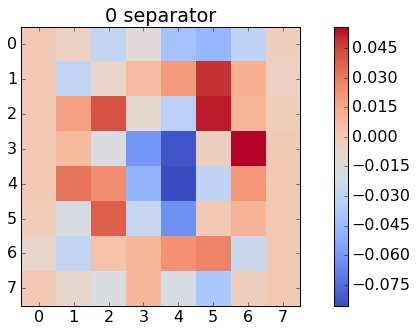

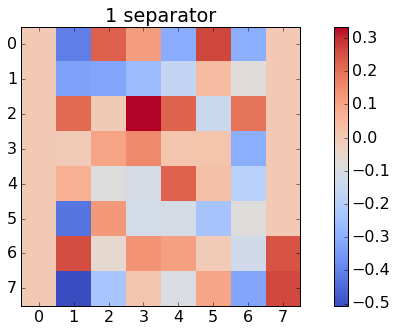

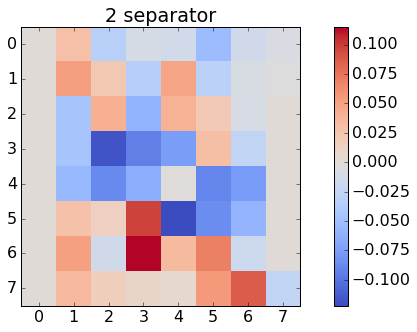

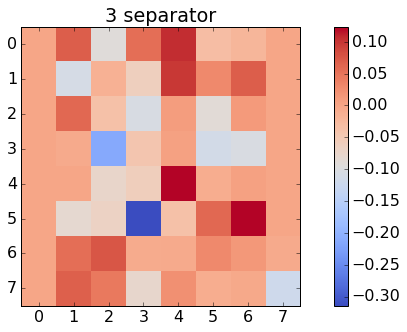

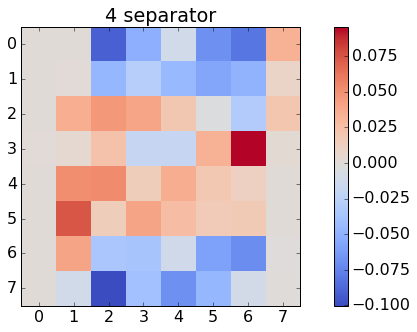

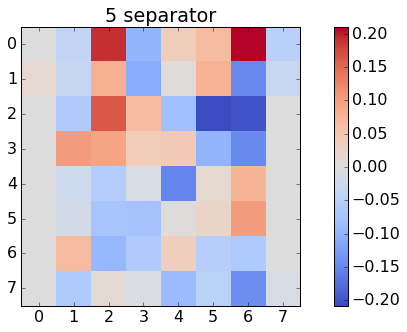

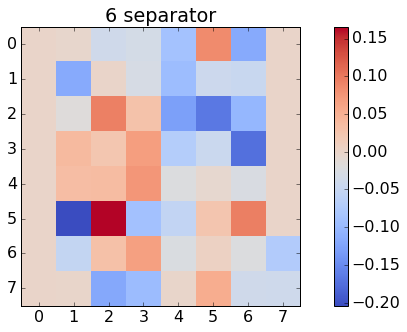

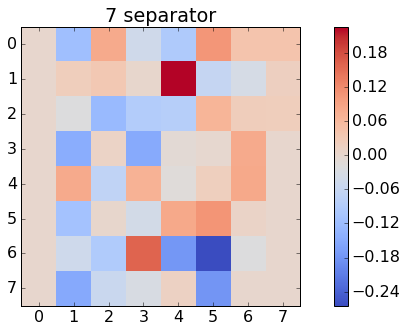

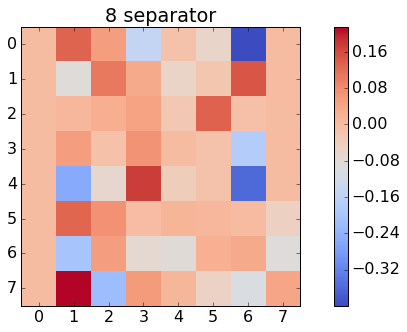

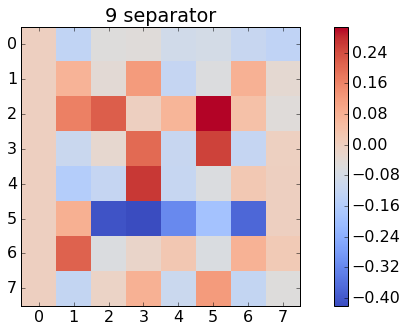

In [6]:
for i in range(10):
    plt.title("{} separator".format(i))
    plt.imshow(lsvc.coef_[i].reshape((8,8)), cmap="coolwarm")
    plt.colorbar()
    plt.show()

There is some clear correlation with the structure of the digits that they are supposed to be separating out for example the zero separator has high values in a zero shape and negative values in the hole area, the 2 separator has structures which would have high values for a diagonal slash going from right to left but low values for an opposite diagonal slash. It is difficult to see exactly why most of the separators work but if we look at the distribution of classification margins it is clear that they are doing a pretty good job. 


In [7]:
#get the hyperplane distances for the SVC
test_trans = np.dot(test, lsvc.coef_.transpose()) + lsvc.intercept_



In [8]:
#verify that this is the value used as the decision function
test_trans - lsvc.decision_function(test)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

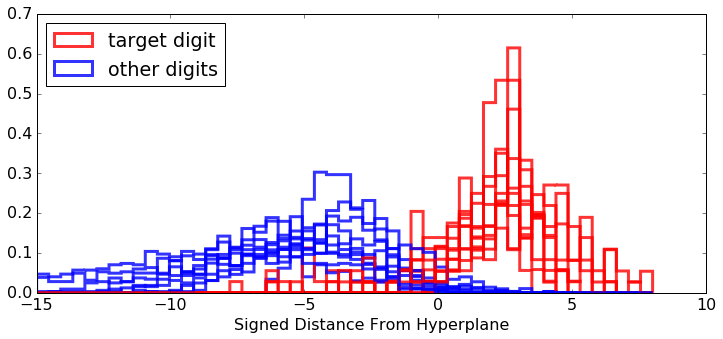

In [9]:
fig, ax = plt.subplots()

hist_kwargs = dict(range=(-15, 8), bins=51, histtype="step", normed=True, lw=3.0, alpha=0.8)

for i in range(10):
    label_mask = test_labels == i
    h1 = ax.hist(test_trans[label_mask, i], color="r", **hist_kwargs)
    h2 = ax.hist(test_trans[np.logical_not(label_mask), i], color="b", **hist_kwargs)

h1[2][0].set_label("target digit") 
h2[2][0].set_label("other digits")
plt.legend(loc=2)

plt.xlabel("Signed Distance From Hyperplane")

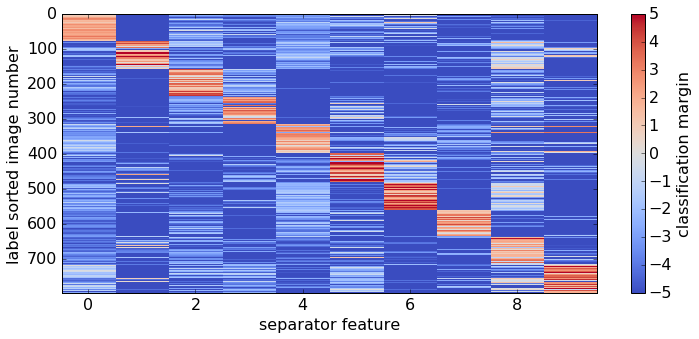

In [10]:
argidxs = np.argsort(test_labels)
plt.imshow(test_trans[argidxs], aspect='auto', cmap="coolwarm", vmax=5.0, vmin=-5)
cbar = plt.colorbar()
cbar.set_label("classification margin")
plt.xlabel("separator feature")
plt.ylabel("label sorted image number")

There are a few oddballs in each category which end up on the wrong side of each hyperplane but each one-vs-rest classifier seems to do a pretty good job.

In [11]:
test_predictions = np.argmax(test_trans, axis=1)
n_err = np.sum(test_labels != test_predictions)
print("{} misclassified test cases".format(n_err))
print("test error rate = {:4.3f}".format(n_err/len(test)))

74 misclassified test cases
test error rate = 0.093


The test error rate of the pure linear SVM isn't great but considering that this amounts to a single matrix multiplication and sorting of the output it is pretty good. Can we do any better by using the individual classifier margins as input features into a different classifier? Effectively treating the SVC as a dimensionality reducer? From the histograms above it is clear that in this 10 dimensional space our data looks somewhat similar to 10 different bumps each one centered on a vector with one positive mean and negative means in the other dimensions. Lets try Gaussian Naive Bayes and see what happens.

In [12]:
train_trans = lsvc.decision_function(train)

gnb = sklearn.naive_bayes.GaussianNB().fit(train_trans, train_labels)

gnb_pred = gnb.predict(test_trans)

n_err_gnb = np.sum(test_labels != gnb_pred)
print("{} misclassified test cases".format(n_err_gnb))
print("test error rate = {:4.3f}".format(n_err_gnb/len(test)))

63 misclassified test cases
test error rate = 0.079


We do see an improvement over the LinearSVC by itself but Naive Bayes would have no trouble working in the full dimensional space. What error rate would GaussianNB achieve all on its own?

In [13]:
gnb_raw = sklearn.naive_bayes.GaussianNB().fit(train, train_labels)
gnb_pred_raw = gnb_raw.predict(test)
n_err_gnb_raw = np.sum(test_labels != gnb_pred_raw)
print("{} misclassified test cases".format(n_err_gnb_raw))
print("test error rate = {:4.3f}".format(n_err_gnb_raw/len(test)))

165 misclassified test cases
test error rate = 0.207


Without the LinearSVC acting as a dimensionality reduction layer the naive bayes has a test error of nearly 20% for this dataset. 

It is nice that naive bayes works well with the linear SVC as a dimensionality reducer but we know from experience that using a kernelized SVC on this data set can do better by itself. Lets see if we can get improved performance using the usual non-linear SVC implementation with the rbf kernel.

In [14]:
svc = SVC(kernel="rbf", gamma=0.003, decision_function_shape="ovo")
svc.fit(train, train_labels)
svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.003, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
test_pred_nl = svc.predict(test)
n_err_nl = np.sum(test_labels != test_pred_nl)
print("{} misclassified test cases".format(n_err_nl))
print("test error rate = {:4.3f}".format(n_err_nl/len(test)))

35 misclassified test cases
test error rate = 0.044


The SVC classifier by itself does a really good job here. One important thing to note here is that actually a good bit of the performance improvement of the SVC implementation over the LinearSVC implementation is due to the use of an one-vs-one multi-class voting scheme rather than from the use of the SVM algorithm itself. Looking at the classification margins we can see that we train classifiers for every pair of categories. This makes for very interesting decision function structure but the high correlation between the values makes GaussianNB behave poorly.

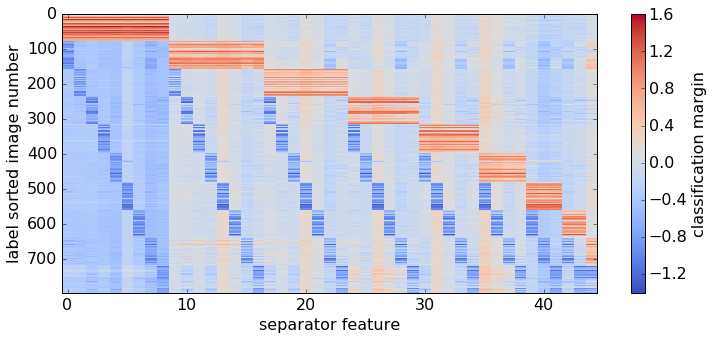

In [16]:
train_trans_nl = svc.decision_function(train)
test_trans_nl = svc.decision_function(test)

plt.imshow(test_trans_nl[argidxs], aspect='auto', cmap="coolwarm")
cbar = plt.colorbar()
cbar.set_label("classification margin")
plt.xlabel("separator feature")
plt.ylabel("label sorted image number")

In [17]:
gnb_nl = sklearn.naive_bayes.GaussianNB().fit(train_trans_nl, train_labels)
gnb_pred_nl = gnb_nl.predict(test_trans_nl)

n_err_gnb_nl = np.sum(test_labels != gnb_pred_nl)
print("{} misclassified test cases".format(n_err_gnb_nl))
print("test error rate = {:4.3f}".format(n_err_gnb_nl/len(test)))

122 misclassified test cases
test error rate = 0.153


Instead of getting an improvement in our test error rate we get a worse error rate. However this is mostly due to the fact that naive bayes doesn't work well in cases where the features are sharing a lot of information and this is cleary the case here. There is an option in the SVC object to collapse the decision function down to the same shape we would get from an one-vs-rest voting scheme but this still uses the underlying one-vs-one fit classifiers.

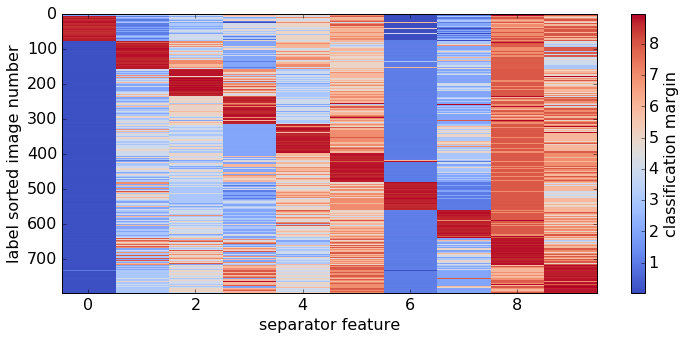

In [18]:
svc.decision_function_shape = "ovr"

train_trans_nl = svc.decision_function(train)
test_trans_nl = svc.decision_function(test)

plt.imshow(test_trans_nl[argidxs], aspect='auto', cmap="coolwarm")
cbar = plt.colorbar()
cbar.set_label("classification margin")
plt.xlabel("separator feature")
plt.ylabel("label sorted image number")

The structure once we collapse back down to an one-vs-rest sort of scheme still has the ear marks of the one-vs-one scheme. The separators built to distinguish eights from other categories had a fair amount of trouble whereas every separator was able to cleanly separate the zeros. There is no obvious correlation between the values of the collapsed separators and so Naive Bayes might have a chance again. However another trouble with GaussianNB is that it doesn't handle complex distributions very well. The distribution of any one of our separators might look somewhat gaussian by itself but their joint distribution certainly does not.

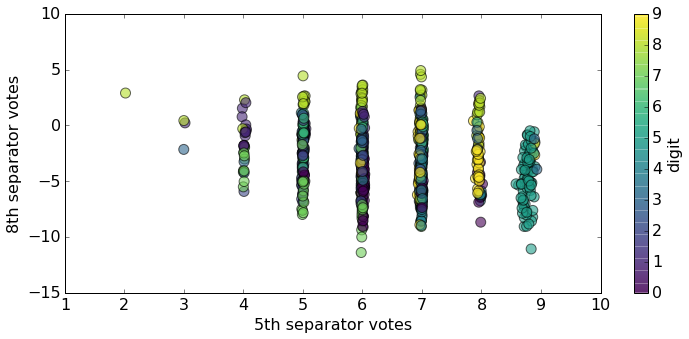

In [19]:
plt.scatter(
    test_trans_nl[:, 5], 
    test_trans[:, 8], 
    c=test_labels, 
    cmap="viridis",
    s=100,
    alpha=0.6
)
cbar = plt.colorbar()
cbar.set_label("digit")
plt.xlabel("5th separator votes")
plt.ylabel("8th separator votes")

In [20]:
gnb_nl = sklearn.naive_bayes.GaussianNB().fit(train_trans_nl, train_labels)
gnb_pred_nl = gnb_nl.predict(test_trans_nl)

n_err_gnb_nl = np.sum(test_labels != gnb_pred_nl)
print("{} misclassified test cases".format(n_err_gnb_nl))
print("test error rate = {:4.3f}".format(n_err_gnb_nl/len(test)))

38 misclassified test cases
test error rate = 0.048


Despite this difficulty switching the decision function shape option from "ovo" to "ovr" allows the GaussianNB to behave tolerably well although we did lose a bit of accuracy given this particular setup. However we now have a natural way to evaluate probabilities which are often nicer to deal with than distances. However as is common for Naive Bayes these probabilities tend to be unrealistically skewed towards 0 and 1.

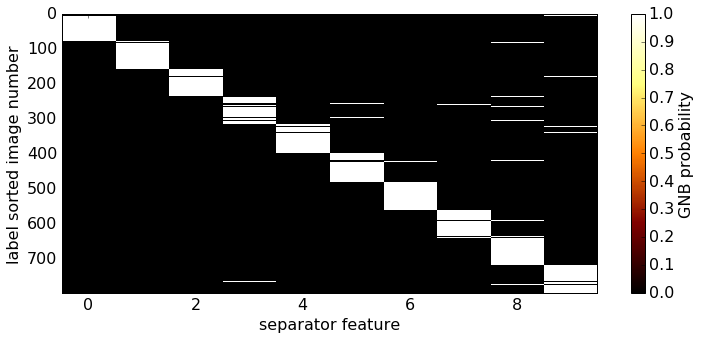

In [57]:
gnb_nl_probs = gnb_nl.predict_proba(test_trans_nl)

plt.imshow(gnb_nl_probs[argidxs], aspect='auto', cmap="afmhot")
cbar = plt.colorbar()
cbar.set_label("GNB probability")
plt.xlabel("separator feature")
plt.ylabel("label sorted image number")

If we use something with more flexibility like a random forest classifier we fully recover the classifying power that the SVM gave us and a small apparent improvement in the meaningfullness of our probabilities (since nearly all the probabilities in the mid range are mis-classifications. 

35 misclassified test cases
test error rate = 0.044


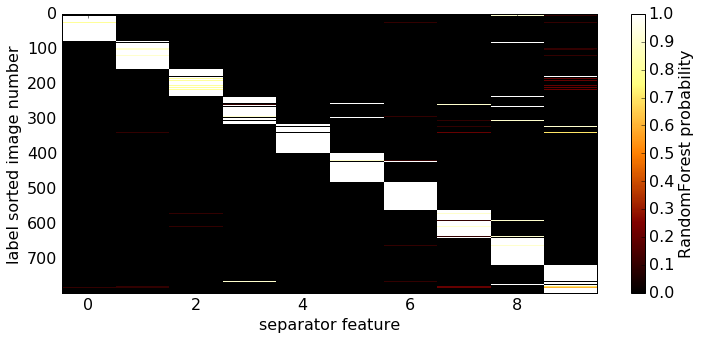

In [61]:
rfc_nl = sklearn.ensemble.RandomForestClassifier()
rfc_nl.fit(train_trans_nl, train_labels)
rfc_nl_pred = rfc_nl.predict(test_trans_nl)
rfc_nl_probs = rfc_nl.predict_proba(test_trans_nl)

n_err_rfc_nl = np.sum(test_labels != rfc_nl_pred)
print("{} misclassified test cases".format(n_err_rfc_nl))
print("test error rate = {:4.3f}".format(n_err_rfc_nl/len(test)))

plt.imshow(rfc_nl_probs[argidxs], aspect='auto', cmap="afmhot")
cbar = plt.colorbar()
cbar.set_label("RandomForest probability")
plt.xlabel("separator feature")
plt.ylabel("label sorted image number")

Also since the RandomForestClassifier is much more robust to features with correlated information we can try to use the full ovo decision function space. In this case though it results in significantly worse classification even if we do a little hand tweaking of the forest parameters.  

165 misclassified test cases
test error rate = 0.207


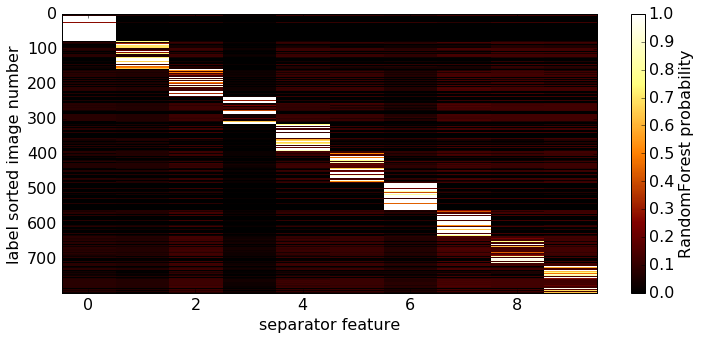

In [74]:
svc.decision_function_shape = "ovo"

train_trans_nl_ovo = svc.decision_function(train)
test_trans_nl_ovo = svc.decision_function(test)

rfc_nl = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_features=21, max_depth=10)
rfc_nl.fit(train_trans_nl_ovo, train_labels)
rfc_nl_pred = rfc_nl.predict(test_trans_nl_ovo)
rfc_nl_probs = rfc_nl.predict_proba(test_trans_nl_ovo)

n_err_rfc_nl = np.sum(test_labels != rfc_nl_pred)
print("{} misclassified test cases".format(n_err_rfc_nl))
print("test error rate = {:4.3f}".format(n_err_rfc_nl/len(test)))

plt.imshow(rfc_nl_probs[argidxs], aspect='auto', cmap="afmhot")
cbar = plt.colorbar()
cbar.set_label("RandomForest probability")
plt.xlabel("separator feature")
plt.ylabel("label sorted image number")



## Thoughts

I have used this trick a number of times in kaggle competitions to get a significant boost in my leaderboard score. Mostly this is not due to the improvement of the predictions themselves but the ease of making tweaks to the output values to optimize the competition metric. Since SVM works in a kernel space it is very hard to optimize for metrics other than the hinge loss. This often drives the choice of a reasonable means of classifying the data but it doesn't easily admit a probability estimate. Using the classification margin as a classification confidence allows us to select appropriate scaling and clippings to maximize the desired metric (e.g. area under the ROC curve) on a held out validation set. This is of course no different in principle from using a stacked classifier as we have done in this post. 

Gaining access to the hyper-plane distance ourselves is particularly useful in cases with very imbalanced classes where it is not at all unusual for the most likely classification for every point to be one class or the other. An additional line of defense in this case is altering the class weights or building a stratified k-fold. But even when applying these other techniques it is often best to also set a best classification threshold by hand.